#  NEURAL NETWORKS AND DEEP LEARNING :

### Group members :

- Mojtaba Roshana

- Asal Rangrazi Asl

- Roya Joulaeivijouyeh

### Project proposals : Image Recoloring with conditional GANs

### Dataset description : (ImageNet-1000)

- The dataset we are using for this project is basically a sample of the well-known and substantial image-net dataset.

- In this project, we trained and evaluated our models using 5000 samples from the dataset.


### Model description :

- Conditional Generative Adversarial Networks (cGAN) is a variant of Generative Adversarial Networks (GANs) where both the generator and the discriminator are conditioned on additional information. In a cGAN, the generator tries to generate data samples based on both a random noise vector and a conditioning input.

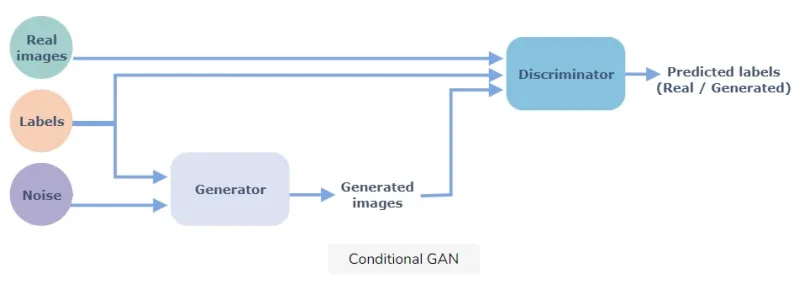

### Main Required Steps :

1. Choose a Dataset and write the Dataset class to transform the images to grayscale.
2. Implement the UNET Autoencoder.(generator)
3. Implement the patch GAN.(discriminator)
4. Setup the losses and train the system.
5. Improve the model with some of the suggestions or propose something yourself.

The paper uses the whole ImageNet dataset (with 1.3 million images!) but here we are using only 5000 images.

### 1.1- Loading Image Paths: 

In [ ]:
#!pip install fastai==2.4

In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [ ]:
device

In [ ]:
import fastai
fastai.__version__

In [ ]:
import torch
torch.__version__

In [ ]:
!cp -R /content/drive/MyDrive/5k /content/

 Downloading data with kaggle API Imagenet mini


In [ ]:
#! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle datasets download ifigotin/imagenetmini-1000

In [ ]:
#! unzip imagenetmini-1000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### loading Dataset :

- colect 5000 data and devide them for training set and test set.


### splitting Data :

- Data splitting is when data is divided into two or more subsets. Typically, with a two-part split, one part is used to evaluate or test the data and the other to train the model. Data splitting is an important aspect of data science, particularly for creating models based on data.

- We assume 80% (4000 images) of data as the train set and 20%  (1000 images) as the validation set.



In [ ]:
#path = "/content/5k/"
path = "/content/drive/MyDrive/ DNN_final_project/5k"

paths = glob.glob(path + "/*.JPEG") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 5000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(5000)
train_idxs = rand_idxs[:4000] # choosing the first 4000 as training set
val_idxs = rand_idxs[4000:] # choosing last 1000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

### this is just simple visualization of dataset :

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

### loading images in machine :

- we use Lab color space instead of RGB to train the models because To train a model for colorization,we should give it a grayscale image and hope that it will make it colorful. When using Lab, we can give the L channel to the model (which is the grayscale image) and want it to predict the other two channels (a, b) and after its prediction, we concatenate all the channels and we get our colorful image.

 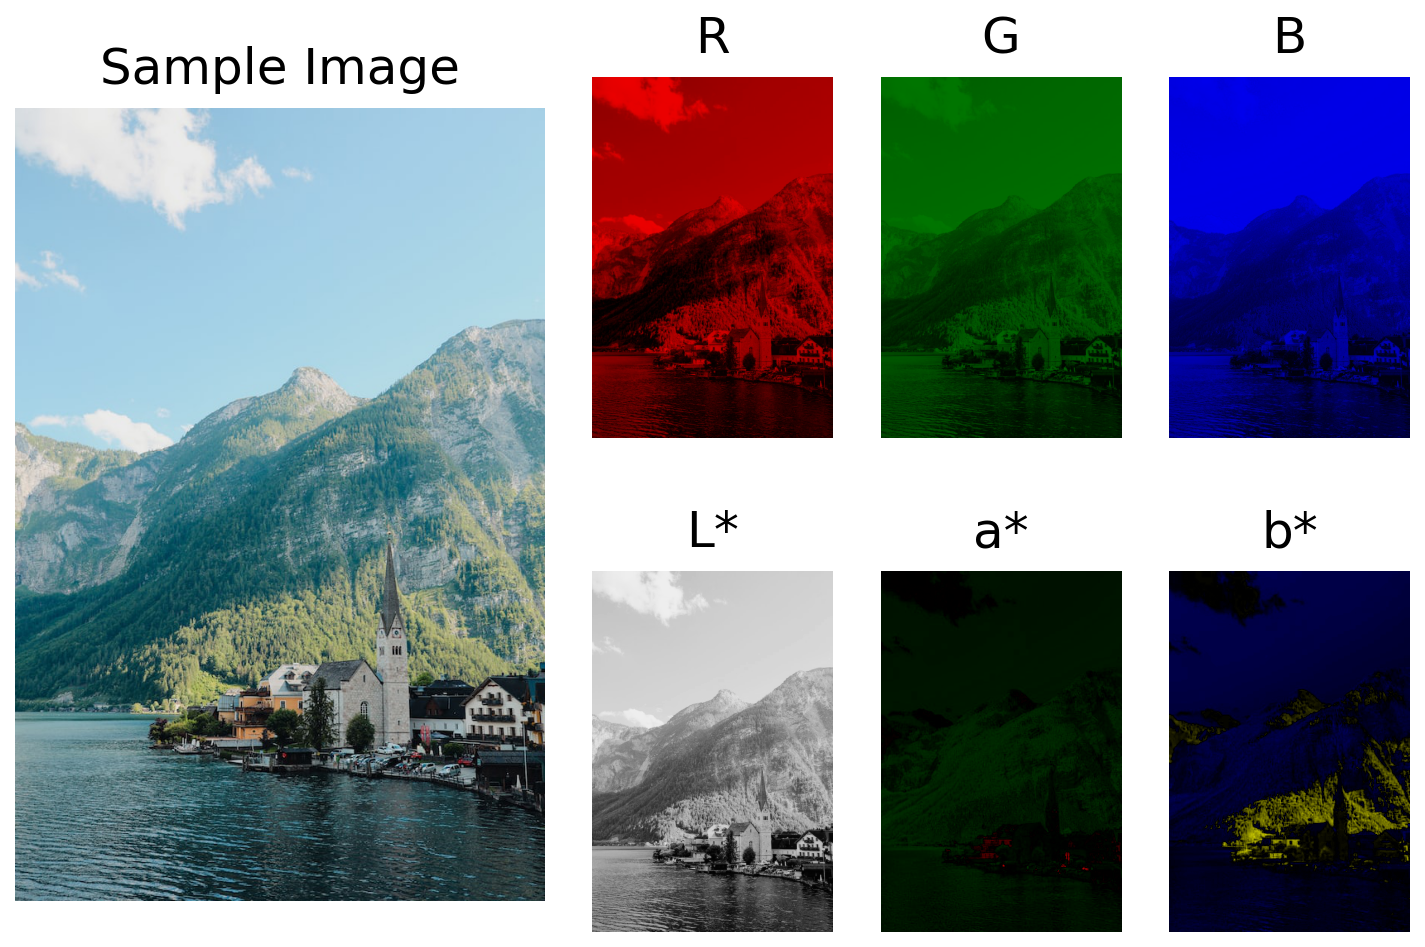

###  Making Datasets and DataLoaders :

We read an RGB image, convert it to Lab color space and separate the first (grayscale) channel and the color channels as my inputs and targets for the models  respectively. Then define the data loaders.

In [ ]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=0, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

###  Generator proposed by the paper : ( U-NET )

- A generator in a Generative Adversarial Network (GAN) is a deep learning model designed to generate new data samples that are similar to a target dataset. A UNet is a specific type of generator architecture that is used for image-to-image translation tasks, such as converting sketches to photographs or masks to color images.

 
 

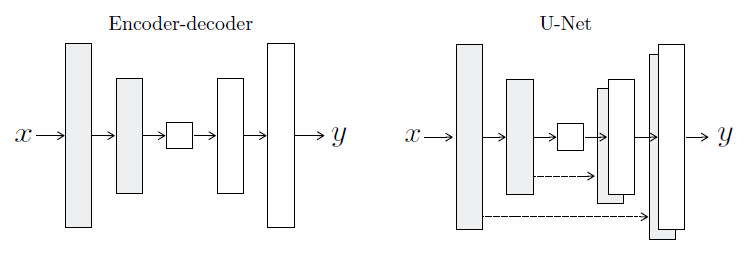

- UNet is composed of an encoder and a decoder, which are mirror images of each other. The encoder compresses the input image into a lower-dimensional feature representation, while the decoder expands the feature representation back into an output image. The encoder and decoder are connected by skip connections, which help to preserve spatial information and improve the quality of the generated image.

- The U-Net we will build has more layers than what is depicted in this image but it suffices to give you the idea. Also notice in the code that we are going 8 layers down, so if we start with a 256 by 256 image, in the middle of the U-Net we will get a 1 by 1 (256 / 2⁸) image and then it gets up-sampled to produce a  256 by 256 image (with two channels).

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

###  Discriminator : (patchGAN)

- PatchGANs are a useful technique for image generation tasks, as they can produce high-quality, realistic images while improving stability and efficiency during training.



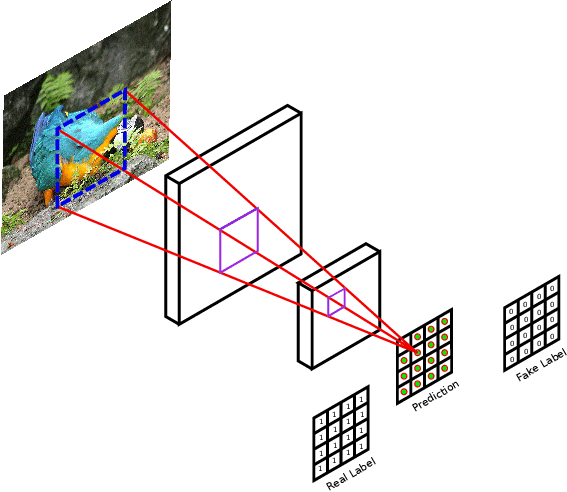

- In a patch discriminator, the model outputs one number for every patch of say 70 by 70 pixels of the input image and for each of them decides whether it is fake or not separately.

- The architecture of our discriminator is rather straight forward. This code implements a model by stacking blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. Notice that the first and last blocks do not use normalization and the last block has no activation function (it is embedded in the loss function we will use).

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
PatchDiscriminator(3)

And its output shape:

In [ ]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

- Here, the model's output shape is 30 by 30 but it does not mean that our patches are 30 by 30. The actual patch size is obtained when you compute the receptive field of each of these 900 (30 multiplied by 30) output numbers which in our case will be 70 by 70.

# GAN Loss:

- The loss function in a cGAN typically consists of two components: the generator loss and the discriminator loss. The generator loss measures how well the generator is able to fool the discriminator, while the discriminator loss measures how well the discriminator is able to distinguish between real and generated samples.

### Generator loss :

- The generator loss is usually defined as the negative log-likelihood of the discriminator's output, given the generated sample and the conditioning input. The generator tries to minimize this loss, which encourages it to generate samples that are classified as real by the discriminator.

### Discriminator loss :
- The discriminator loss measures the binary cross-entropy between the true labels (real or fake) and the discriminator's predictions. The discriminator tries to maximize this loss, which encourages it to produce accurate predictions.

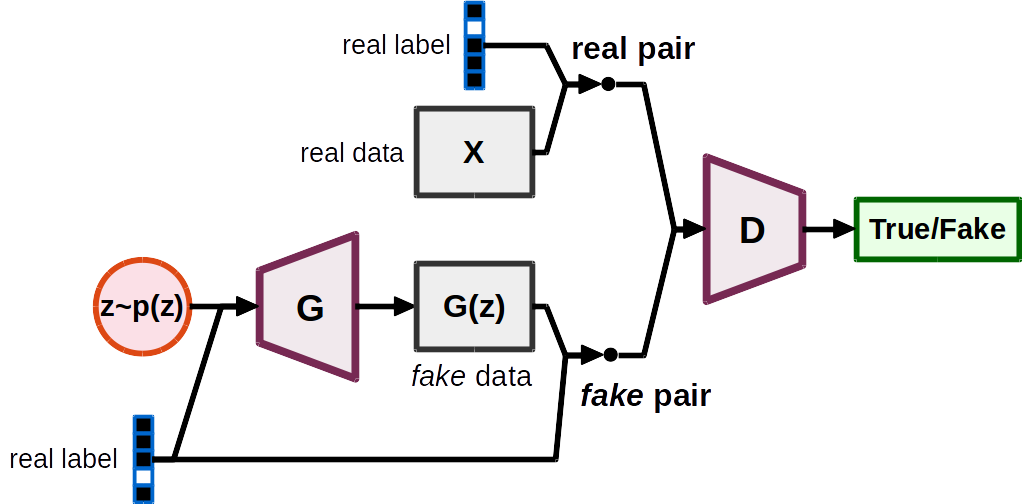

- This is a handy class we can use to calculate the GAN loss of our final model. In the __init__ we decide which kind of loss we're going to use (which will be "vanilla" in our project) and register some constant tensors as the "real" and "fake" labels. Then when we call this module, it makes an appropriate tensor full of zeros or ones (according to what we need at the stage) and computes the loss.

- we use L1 loss as well and compute the distance between the predicted two channels and the target two channels and multiply this loss by a coefficient (which is 100 in our case) to balance the two losses and then add this loss to the adversarial loss. Then we call the backward method of the loss.

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

###  Model Initialization :

- Here is our logic to initialize our models. We are going to initialize the weights of our modelwhich are the proposed hyperparameters in the article, with:

1. mean= 0.0

2. standard deviation = 0.02 

 

In [ ]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

### Main Model :

- step1: This class brings together all the previous parts and implements a few methods to take care of training our complete model.   

- step2: In the __init__  our generator and discriminator using the previous functions and classes which defined and also initialize them with init_model function.

- step 3: using module's forward method (only once per iteration (batch of training set)) and store the outputs in fake_color variable of the class. 

- step4: first train the discriminator by using backward_D method in which we feed the fake images produced by generator to the discriminator and label them as fake.

- step5: Then feed a batch of real images from training set to the discriminator and label them as real. also add up the two losses for fake and real and take the average and then call the backward on the final loss.

- step6: train the generator. In backward_G method feed the discriminator the fake image and try to fool it by assigning real labels to them and calculating the adversarial loss. 

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

### Utility functions :

- some utility functions to log the losses of our network and also visualize the results during training.

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict,show=True):
    res = {}
    for loss_name, loss_meter in loss_meter_dict.items():
        if show:
          print(f"{loss_name}: {loss_meter.avg:.5f}")
        res[loss_name] = loss_meter.avg
    
    return res

### Train Model :

- We train the model for 6 different group of images.

- Every epoch takes about 3 to 4 minutes on Colab.

- We just able to train it for 30 epoch as it took a long time to train.

- But in each step you can see the changes.

- By training this model for more than 50 epoch we can see step by step reasonable results. 

- Also for the perfect result we have to train it in 100 epochs.

In [ ]:
results = []
show=False
def train_model(model, train_dl, epochs, display_every=1):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i in [1,5,10,50,100,249]:
                visualize(model, data, save=False) # function displaying the model's outputs
                show=True
            else:
                show=False
            if show:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
            results.append(log_results(loss_meter_dict,show=show)) # function to print out the losses
                

model = MainModel()
train_model(model, train_dl, 30)

### save the model after training: 

In [ ]:
import pandas as pd
torch.save(model, '/content/drive/MyDrive/ DNN_final_project/model.pt')
df=pd.DataFrame(results)
df.to_csv('/content/drive/MyDrive/ DNN_final_project/raw_data.csv')

### visualization of losses:

- these plots is just for 30 epoches but if you can see even for the 30 epoch we can realize the decreasing of losses.

- if we had the powerfull system, we were able to show these plots for 100 epoches.

In [ ]:
import pandas as pd
#df = pd.read_csv('/content/raw_data.csv')
plt.plot(np.arange(len(df['loss_G']))*10,df['loss_G'])
plt.plot(np.arange(len(df['loss_G']))*10,df['loss_G'])
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)


In [ ]:
plt.figure(figsize=(12, 8), dpi=80)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
for i in df.columns[3:]:
  plt.plot(np.arange(len(df[i])),df[i],label=i)
#plt.yscale("log")
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.xlabel('iteration')


In [ ]:
import pandas as pd
plt.figure(figsize=(12, 8), dpi=80)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
for i in df.columns[:3]:
  plt.plot(np.arange(len(df[i])),df[i],label=i)
plt.yscale("log")
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.xlabel('iteration')


### model summery :

In [ ]:
map_location=torch.device('cpu')
model = torch.load('/content/drive/MyDrive/ DNN_final_project/model.pt')
model.eval()

## Model 2 :


- step.1: The backbone of the generator (the down sampling path) is a pretrained model for classification (on ImageNet)

- step.2: The whole generator will be pretrained on the task of colorization with L1 loss.

- step3: use a pretrained ResNet18 as the backbone of my U-Net(fastai library's).

   - train the U-Net on our training set with only L1 Loss
   
   - move to the combined adversarial and L1 loss, as we did in the previous section.
   
   - create_body function loads the pretrained weights of the ResNet18 architecture.
   
   - cuts the model to remove the last two layers: GlobalAveragePooling and a Linear layer for the ImageNet classifier
   
   - DynamicUnet uses this backbone to build a U-Net with the needed output channels (2 in our case) and with an input size of 256

###  Using a new generator :

In [ ]:
!pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

### Pretraining the generator for colorization task :

- pretrain the generator for 20 epochs & save the weights.

- use this model as the generator for our GAN and train the whole network as before.

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
pretrain_generator(net_G, train_dl, opt, criterion, 1)
torch.save(net_G.state_dict(), "res18-unet.pt")

### Main Model :

In [ ]:
#loading the saved weights for the generator (which you have saved in the previous section)
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl,5)

In [ ]:
torch.save(model, '/content/drive/MyDrive/ DNN_final_project/model1.pt')
df1=pd.DataFrame(results)
df1.to_csv('/content/drive/MyDrive/ DNN_final_project/raw_data1.csv')

In [ ]:
map_location=torch.device('cpu')
model = torch.load('/content/drive/MyDrive/ DNN_final_project/model1.pt')
model.eval()

In [ ]:
#!pip install --upgrade --no-cache-dir gdown


In [ ]:
 #!gdown --id 1lR6DcS4m5InSbZ5y59zkH2mHt_4RQ2KV

In [ ]:
 #net_G = build_res_unet(n_input=1, n_output=2, size=256)
 #net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
 #model = MainModel(net_G=net_G)
 #model.load_state_dict(torch.load("final_model_weights.pt", map_location=device))

### Test the Model :

- As we mentioned before because of our system we were not able to do both models for 100 epoches so when we are testing our models it not gives us reasonable results but we are sure about our model, it will give good performance when we will do it by 100 epoches.

- just for showing our models performance we find the trained result of similar model & visualized it here.

In [ ]:
p=path[:len(path)-4]
test=glob.glob(p+ "/*.jfif")

In [ ]:
test_data=make_dataloaders(paths=test, split='val')


In [ ]:
#for data in tqdm(train_dl):
 #visualize(model,data , save=False)

### Coco Data set:

- As we already used the pre-trained model for the imagenet, it was not reasonable to use same dataset to test.

- for showing final result we test the coco dataset.

In [ ]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [ ]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"
    
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset_coco = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly


In [ ]:
test_coco = make_dataloaders(paths=paths_subset_coco, split='val')
print(len(test_coco))

In [ ]:
for data in tqdm(test_coco):
  visualize(model,data , save=False)